In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

from PIL import Image
from glob import glob
import os

Mounted at /content/gdrive


In [2]:
def resize_images(img_path, target_size):
    img_types = ["paper", "rock", "scissors"]
    if not os.path.isdir("/content/gdrive/MyDrive/deep-learning"):
        os.mkdir("/content/gdrive/MyDrive/deep-learning")
    for img_type in img_types:
        resized_img_path = "/content/gdrive/MyDrive/deep-learning/" + img_type
        if not os.path.isdir(resized_img_path):
            os.mkdir(resized_img_path)
        img_list = glob(img_path + "/" + img_type + "/*")
        for i, img in enumerate(img_list):
            original_img = Image.open(img).convert('RGB')
            resized_img = original_img.resize(target_size, Image.ANTIALIAS)
            img_name = img.split("/")[-1]
            resized_img.save(resized_img_path + "/" + img_name, 'png')
        print(img_type, " : ", len(img_list), "DONE")

In [3]:
resize_images("/content/gdrive/MyDrive/deeplearning", (128, 128))

paper  :  1026 DONE
rock  :  1026 DONE
scissors  :  1020 DONE


In [4]:
import numpy as np
import glob

def load_data(img_path, img_size):  # 가위바위보 이미지 개수 총합에 주의
    paper = glob.glob(img_path + "/paper/*")
    rock = glob.glob(img_path + "/rock/*")
    scissors = glob.glob(img_path + "/scissors/*")
    number_of_data = len(paper) + len(rock) + len(scissors)
    color=3
    #이미지 데이터와 라벨(주먹 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs = np.zeros(number_of_data * img_size * img_size * color,
                    dtype = np.int32)\
        .reshape(number_of_data, img_size, img_size, color)
    labels=np.zeros(number_of_data ,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/rock/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 주먹 : 0
        idx=idx+1

    for file in glob.iglob(img_path+'/scissors/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=1   # 가위 : 1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/paper/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=2   # 보 : 2
        idx=idx+1

    return imgs, labels

# 새 섹션

In [5]:
image_dir_path = "/content/gdrive/MyDrive/deep-learning"
(x, y)=load_data(image_dir_path, 128)
x_norm = x/255.0   # 입력은 0~1 사이의 값으로 정규화

print(f"x_train shape: {x.shape}")
print(f"y_train shape: {y.shape}")

x_train shape: (3072, 128, 128, 3)
y_train shape: (3072,)


x_train shape: (3072, 128, 128, 3)
라벨:  0


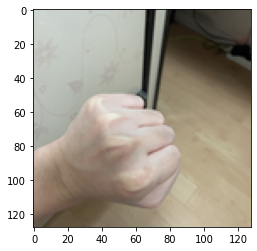

In [6]:
import matplotlib.pyplot as plt

plt.imshow(x[1000])
print(f"x_train shape: {x.shape}")
print('라벨: ', y[0])

In [7]:
def train_val_test_split(ds, sd, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True):
    assert (train_split + test_split + val_split) == 1
    
    if shuffle:
        # trainning set, validation set, test set 을 동일하게 섞기 위해 seed 를 설정
        ds_shuffled = np.random.RandomState(seed=sd).permutation(ds)
    
    train_size = int(train_split * len(ds))
    val_size = int(val_split * len(ds))
    
    train_ds = ds_shuffled[0:train_size]    
    val_ds = ds_shuffled[train_size:train_size+val_size]
    test_ds = ds_shuffled[train_size+val_size:]
    
    return train_ds, val_ds, test_ds

x_train, x_val, x_test = train_val_test_split(x,30)
y_train, y_val, y_test = train_val_test_split(y,30)

In [8]:
print(x_train.shape)
print(x_val.shape)
print(x_test.shape)

print(y_train.shape)
print(y_val.shape)
print(y_test.shape)

(2457, 128, 128, 3)
(307, 128, 128, 3)
(308, 128, 128, 3)
(2457,)
(307,)
(308,)


In [9]:
import tensorflow as tf
from tensorflow import keras

model=keras.models.Sequential()
model.add(keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(128 ,128,3)))
model.add(keras.layers.MaxPool2D(2,2))
model.add(keras.layers.Conv2D(32, (3,3), activation='relu'))
model.add(keras.layers.MaxPooling2D((2,2)))
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(32, activation='relu'))
model.add(keras.layers.Dense(3, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 28800)             0         
                                                                 
 dense (Dense)               (None, 32)                9

In [10]:
x_train_norm = x_train / 255.0

model.compile(optimizer = 'adam',
             loss = 'sparse_categorical_crossentropy',
             metrics = ['accuracy'])

model.fit(x_train_norm, y_train, epochs=10)

Epoch 1/10
77/77 [==============================] - 11s 11ms/step - loss: 1.1723 - accuracy: 0.3944
Epoch 2/10
77/77 [==============================] - 1s 9ms/step - loss: 1.0026 - accuracy: 0.5246
Epoch 3/10
77/77 [==============================] - 1s 9ms/step - loss: 0.8310 - accuracy: 0.6256
Epoch 4/10
77/77 [==============================] - 1s 9ms/step - loss: 0.6181 - accuracy: 0.7538
Epoch 5/10
77/77 [==============================] - 1s 9ms/step - loss: 0.4149 - accuracy: 0.8425
Epoch 6/10
77/77 [==============================] - 1s 9ms/step - loss: 0.3202 - accuracy: 0.8852
Epoch 7/10
77/77 [==============================] - 1s 9ms/step - loss: 0.2216 - accuracy: 0.9267
Epoch 8/10
77/77 [==============================] - 1s 9ms/step - loss: 0.1458 - accuracy: 0.9524
Epoch 9/10
77/77 [==============================] - 1s 9ms/step - loss: 0.1116 - accuracy: 0.9695
Epoch 10/10
77/77 [==============================] - 1s 9ms/step - loss: 0.0610 - accuracy: 0.9858


In [11]:
test_loss, test_accuracy = model.evaluate(x_test / 255.0, y_test, verbose = 2)

print("최종 test_loss : {}".format(test_loss))
print("최종 test_accuracy : {}".format(test_accuracy))

10/10 - 0s - loss: 1.3379 - accuracy: 0.6818 - 241ms/epoch - 24ms/step
최종 test_loss : 1.3379367589950562
최종 test_accuracy : 0.6818181872367859


In [12]:
val_loss, val_accuracy = model.evaluate(x_val / 255.0, y_val, verbose = 2)

print("test_loss : {}".format(val_loss))
print("test_accuracy : {}".format(val_accuracy))

10/10 - 0s - loss: 1.7359 - accuracy: 0.6319 - 129ms/epoch - 13ms/step
test_loss : 1.7358514070510864
test_accuracy : 0.6319218277931213


In [16]:
predictions = model.predict(x_val)

print("y_test = ", y_val[20:40])
print("predic = ", np.argmax(predictions[20:40], axis=1))


y_test =  [0 2 1 2 0 2 0 0 1 2 2 0 0 1 2 1 0 1 0 0]
predic =  [0 2 2 2 2 2 0 0 1 0 2 0 0 1 2 2 0 2 0 0]


테스트

In [51]:
from glob import glob
def resize_images(img_path, target_size):

    if not os.path.isdir("/content/gdrive/MyDrive/test2"):
        os.mkdir("/content/gdrive/MyDrive/test2")
    
    resized_img_path = "/content/gdrive/MyDrive/test2"
    img_list = glob(img_path + "/*")
    for i, img in enumerate(img_list):
        original_img = Image.open(img).convert('RGB')
        resized_img = original_img.resize(target_size, Image.ANTIALIAS)
        img_name = img.split("/")[-1]
        resized_img.save(f'/content/gdrive/My Drive/test2/{i}.png','png')

In [52]:
resize_images("/content/gdrive/MyDrive/test", (128, 128))

In [53]:
import numpy as np
import glob

def load_test(img_path, img_size):  # 가위바위보 이미지 개수 총합에 주의
    paper = glob.glob(img_path + "/test2/*")
    number_of_data = len(paper)
    # 가위 : 0, 바위 : 1, 보 : 2
    color=3
    #이미지 데이터와 라벨(가위 : 0, 바위 : 1, 보 : 2) 데이터를 담을 행렬(matrix) 영역을 생성
    imgs = np.zeros(number_of_data * img_size * img_size * color,
                    dtype = np.int32)\
        .reshape(number_of_data, img_size, img_size, color)
    labels=np.zeros(number_of_data ,dtype=np.int32)

    idx=0
    for file in glob.iglob(img_path+'/test2/*.png'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img    # 데이터 영역에 이미지 행렬을 복사
        labels[idx]=0   # 가위 : 0
        idx=idx+1


    return imgs, labels

In [54]:
image_dir_path = "/content/gdrive/MyDrive"
(x, y)=load_test(image_dir_path, 128)
x_norm = x/255.0   # 입력은 0~1 사이의 값으로 정규화

print(f"x_train shape: {x.shape}")
print(f"y_train shape: {y.shape}")



x_train shape: (11, 128, 128, 3)
y_train shape: (11,)


x_train shape: (11, 128, 128, 3)
라벨:  0


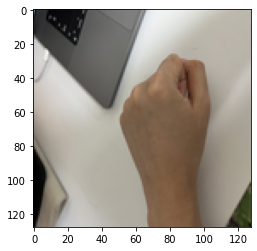

In [55]:
import matplotlib.pyplot as plt

plt.imshow(x[3])
print(f"x_train shape: {x.shape}")
print('라벨: ', y[2])

In [56]:
predictions = model.predict(x)

print("y_test = ", y_test[:100])
print("predic = ", np.argmax(predictions[:100], axis=1))



y_test =  [1 0 2 1 2 0 0 1 2 0 2 0 0 2 0 1 1 0 2 0 2 0 2 0 1 1 2 0 1 0 1 1 1 0 1 1 2
 1 0 2 0 0 0 0 1 0 2 2 2 1 2 2 2 1 2 2 0 1 2 1 2 2 1 0 2 0 2 2 1 0 2 0 0 1
 0 2 0 2 0 2 2 1 1 1 0 1 1 2 1 2 2 1 2 0 2 1 1 0 0 0]
predic =  [2 2 2 2 1 1 2 1 2 2 1]


In [139]:
model.predict(x_norm)

array([[9.9958783e-01, 4.8050570e-05, 3.6415417e-04],
       [9.7044748e-01, 2.3280995e-02, 6.2716305e-03],
       [5.4187137e-01, 6.2623949e-06, 4.5812231e-01]], dtype=float32)

In [140]:
predictions[0]

array([9.9958783e-01, 4.8050570e-05, 3.6415417e-04], dtype=float32)

In [142]:
np.argmax(predictions[0])

0